# Dungeons & Dragons Nerual Network Project

## Loading the Data

This section is mainly just importing modules and opening all the files containing the stored data from get_data

In [81]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2, l1
from sklearn.metrics import classification_report
import json

# Display all rows
pd.set_option('display.max_rows', None)
# Display all columns
pd.set_option('display.max_columns', None)

def load_and_encode_data():
    global label_encoder
    with open('aberrations_array.json', 'r') as f:
        aberrations_array = json.load(f)
    aberrations_array = [np.array(arr) for arr in aberrations_array]

    with open('beasts_array.json', 'r') as f:
        beasts_array = json.load(f)
    beasts_array = [np.array(arr) for arr in beasts_array]

    with open('celestials_array.json', 'r') as f:
        celestials_array = json.load(f)
    celestials_array = [np.array(arr) for arr in celestials_array]

    with open('constructs_array.json', 'r') as f:
        constructs_array = json.load(f)
    constructs_array = [np.array(arr) for arr in constructs_array]

    with open('dragons_array.json', 'r') as f:
        dragons_array = json.load(f)
    dragons_array = [np.array(arr) for arr in dragons_array]

    with open('elementals_array.json', 'r') as f:
        elementals_array = json.load(f)
    elementals_array = [np.array(arr) for arr in elementals_array]

    with open('fey_array.json', 'r') as f:
        fey_array = json.load(f)
    fey_array = [np.array(arr) for arr in fey_array]

    with open('fiends_array.json', 'r') as f:
        fiends_array = json.load(f)
    fiends_array = [np.array(arr) for arr in fiends_array]

    with open('giants_array.json', 'r') as f:
        giants_array = json.load(f)
    giants_array = [np.array(arr) for arr in giants_array]

    with open('monstrosoties_array.json', 'r') as f:
        monstrosoties_array = json.load(f)
    monstrosoties_array = [np.array(arr) for arr in monstrosoties_array]

    with open('oozes_array.json', 'r') as f:
        oozes_array = json.load(f)
    oozes_array = [np.array(arr) for arr in oozes_array]

    with open('plants_array.json', 'r') as f:
        plants_array = json.load(f)
    plants_array = [np.array(arr) for arr in plants_array]

    with open('undead_array.json', 'r') as f:
        undead_array = json.load(f)
    undead_array = [np.array(arr) for arr in undead_array]

    data = aberrations_array + beasts_array + celestials_array + constructs_array + dragons_array + elementals_array + fey_array + fiends_array + giants_array + monstrosoties_array + oozes_array + plants_array + undead_array
    labels = ['Aberrations'] * len(aberrations_array) + ['Beasts'] * len(beasts_array) + ['Celestials'] * len(celestials_array) + ['Constructs'] * len(constructs_array) + ['Dragons'] * len(dragons_array) + ['Elementals'] * len(elementals_array) + ['Fey'] * len(fey_array) + ['Fiends'] * len(fiends_array) + ['Giants'] * len(giants_array) + ['Monstrosoties'] * len(monstrosoties_array) + ['Oozes'] * len(oozes_array) + ['Plants'] * len(plants_array) + ['Undead'] * len(undead_array)
    # Encode labels to numerical format
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    data = pd.DataFrame(data)

    data = np.array(data)

    # Split the data into training and testing sets
    
    X_train, X_test, y_train, y_test = train_test_split(data, encoded_labels, stratify=encoded_labels, test_size=0.2, random_state=81)
    return X_train, X_test, y_train, y_test, label_encoder


In [82]:
from keras.callbacks import ReduceLROnPlateau

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test, label_encoder = load_and_encode_data()

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Include the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Build the model (add any additional layers, units, etc. as needed)
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=l1(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(len(np.unique(label_encoder.classes_)), activation='softmax'))

# Compile the model with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with adjusted parameters
history = model.fit(X_train, y_train,
                    epochs=1000,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    class_weight=class_weight_dict,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
                               lr_scheduler])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions and display classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))

Epoch 1/1000


C:\Users\bench\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0735 - loss: 18.6453 - val_accuracy: 0.0745 - val_loss: 17.2351 - learning_rate: 0.0010
Epoch 2/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1256 - loss: 17.7803 - val_accuracy: 0.1277 - val_loss: 16.6812 - learning_rate: 0.0010
Epoch 3/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1271 - loss: 17.4035 - val_accuracy: 0.2128 - val_loss: 16.1655 - learning_rate: 0.0010
Epoch 4/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1471 - loss: 16.3735 - val_accuracy: 0.2234 - val_loss: 15.6606 - learning_rate: 0.0010
Epoch 5/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2144 - loss: 15.6897 - val_accuracy: 0.2234 - val_loss: 15.1779 - learning_rate: 0.0010
Epoch 6/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2003 - loss: 15.2716 - val_accuracy: 0.2447 - val_loss: 14.7063 - learning_rate: 0.0010
Epoch 7/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2307 - loss: 14.4603 -

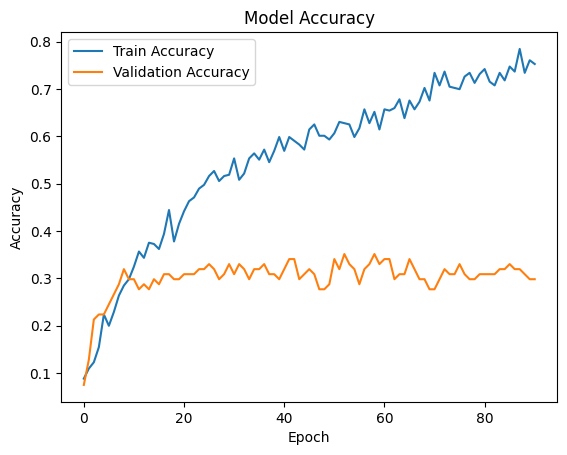

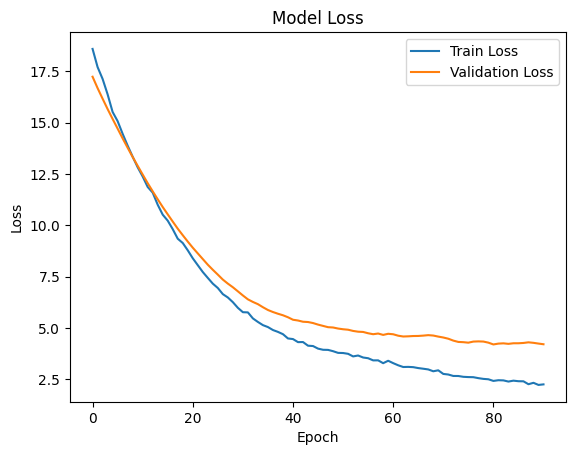

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()